<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-13 08:11:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-04-13 08:11:12 (11.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

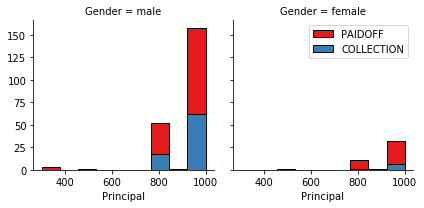

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

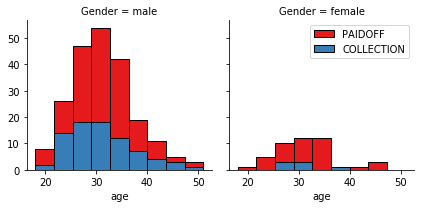

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

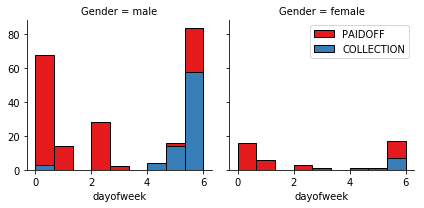

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek #converts The day of the week with Monday=0, Sunday=6
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True) # to drop dummy variable, we can drop any columns
print(Feature.shape)
Feature.head()

(346, 8)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?
* __PAIDOFF as '0' and COLLECTION as '1'__

In [18]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

In [19]:
a = df['loan_status'].value_counts()
a

1    260
0     86
Name: loan_status, dtype: int64

In [20]:
class_wt = {0: np.round(a[1]/np.sum(a), 2), 1: np.round(a[0]/np.sum(a), 2)}
class_wt

{0: 0.75, 1: 0.25}

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

Let's split the data with 25% as test data and 75% as train data

In [22]:
# for AUC vs hyperparamter plot
def auc_hype_plot(k, train_auc, cv_auc, hyper = 'k'):
    plt.figure(figsize = (10,6))
    plt.plot(k, train_auc, 'bo-', label = 'Train AUC')
    plt.plot(k, cv_auc, 'go-', label = 'cv AUC')
    plt.title('AUC of train and cv v/s '+str(hyper)+'-hypreparameter', fontsize = 17)
    plt.legend(fontsize = 15)
    plt.grid('on')
    plt.xlabel('hyperparameter-'+str(hyper), fontsize = 15)
    plt.ylabel('AUC', fontsize = 15)
    plt.show()

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

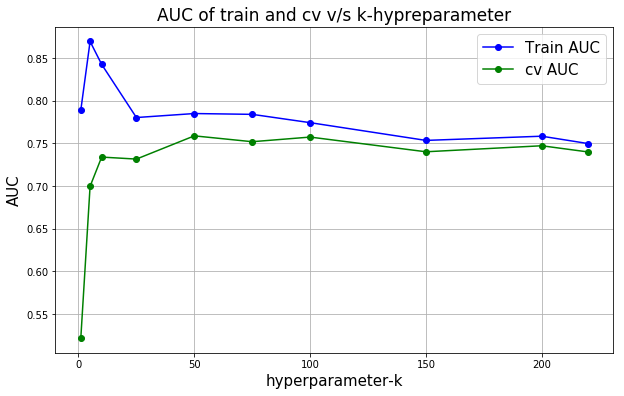

In [24]:
K = [1,5,10,25,50,75,100,150,200,220]
parameters = dict({'n_neighbors': K})

knn = KNeighborsClassifier(algorithm= 'auto', n_jobs=-1)
clf = GridSearchCV(knn, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)

train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

auc_hype_plot(K, train_auc, cv_auc)

* Best value of __k is 10__ becasue cv is giving best AUC at k = 10 

In [25]:
knn_clf = KNeighborsClassifier(n_neighbors = 50, algorithm= 'auto', n_jobs=-1)
knn_clf.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform')

# Decision Tree

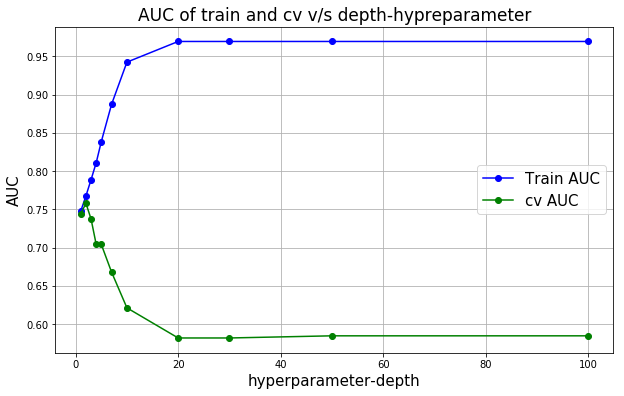

In [26]:
from sklearn.tree import DecisionTreeClassifier

depth = [1, 2, 3, 4, 5, 7, 10, 20, 30, 50, 100]
parameters = dict({'max_depth': depth})

DT = DecisionTreeClassifier(class_weight = class_wt)
clf = GridSearchCV(DT, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)

train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

auc_hype_plot(depth, train_auc, cv_auc, hyper = 'depth')

* __best depth is 2__

In [27]:
DT_clf = DecisionTreeClassifier(max_depth = 2, class_weight = class_wt)
DT_clf.fit(X,y)

DecisionTreeClassifier(class_weight={0: 0.75, 1: 0.25}, criterion='gini',
            max_depth=2, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

**Here I'm tunning only hyper-paramter C (not the gamma or (also known as sigma))**

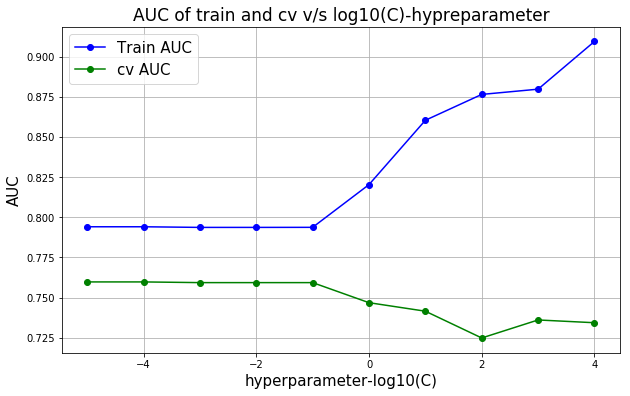

In [28]:
from sklearn.svm import SVC

c = np.array([10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000])
parameters = dict({ 'C': c})
                  
svc = SVC( kernel= 'rbf', gamma= 'auto', class_weight = class_wt, probability = True)
clf = GridSearchCV(svc, parameters, scoring = 'roc_auc', cv = 10)
clf.fit(X, y)

train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

auc_hype_plot(np.log10(c), train_auc, cv_auc, hyper = 'log10(C)')

* Best value of __C is 10**-1__

In [29]:
svm_clf = SVC(C = 10**-1, kernel= 'rbf', gamma= 'auto', class_weight = class_wt, probability = True)
svm_clf.fit(X, y)

SVC(C=0.1, cache_size=200, class_weight={0: 0.75, 1: 0.25}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

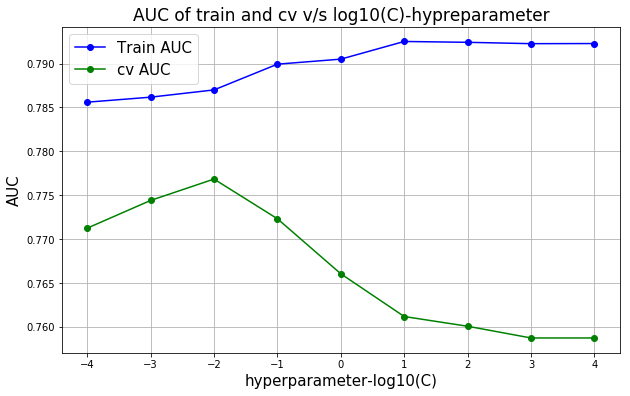

In [30]:
from sklearn.linear_model import LogisticRegression

lamda = np.array([10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000])
c = 1/lamda[::-1] #[::-1] is used to return the array in reverse order
parameters = dict({ 'C': c})

LR = LogisticRegression(penalty = 'l2', class_weight= class_wt) #L2 norm
clf = GridSearchCV(LR, parameters, scoring = 'roc_auc', cv = 5)
clf.fit(X, y)

train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

auc_hype_plot(np.log10(c), train_auc, cv_auc, hyper = 'log10(C)')

* __best value of hyperparameter is C = 10**-2 i.e. lambda = 1/C = 100__

In [31]:
LR_clf = LogisticRegression(penalty = 'l2', C = 10**-2, class_weight= class_wt) #L2 norm
LR_clf.fit(X,y)

LogisticRegression(C=0.01, class_weight={0: 0.75, 1: 0.25}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [32]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-13 08:12:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-13 08:12:08 (660 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [34]:
test_df = pd.read_csv('loan_test.csv')
print(test_df.shape)
test_df.head()

(54, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


#### Data cleaning

In [35]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])#to change into date format

test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])#to change into date format

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek #converts The day of the week with Monday=0, Sunday=6

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) #gender categorical variable into numbers

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) #converting day of week into weekend
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [36]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace = True) # to drop dummy variable, we can drop any columns

print(test_Feature.shape)
test_Feature.head()

(54, 8)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Feature Selection

In [37]:
x_test = test_Feature
x_test= preprocessing.StandardScaler().fit(x_test).transform(x_test)
x_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

What are our lables?
* __PAIDOFF as '1' and COLLECTION as '0'__

In [38]:
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_test = test_df['loan_status'].values
print(y_test.shape)
y_test[0:5]

(54,)


array([1, 1, 1, 1, 1])

__Log-Loss in scikit-learn__
* to find the log-loss value we need to pass the predicted probabilitie by the model if you'll pass the predicted class, then it will consider the maximum probability and you'll get maximum log-loss value.
* If you're passing 1-D array, it'll (libarary) take that as the probability of positive class. So if you are passig 1-D array pass the probability of postive class (e.g. y_pred_prob[:,1]). 
* If you've 2-D array (prdicted by model using predict_proba(X)), it's better to pass the whole predicted numpy array. If array is to big then use above step (y_pred_prob[:,1]).
* For more deatils see the documentation of log-loss (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

In [40]:
y_pred = knn_clf.predict(x_test)
y_pred_prob = knn_clf.predict_proba(x_test)

log_loss_knn = log_loss(y_test, y_pred)
print("If you'll pass the predicted class labes: ",log_loss_knn)

log_loss_knn = log_loss(y_test, y_pred_prob[:,0])
print("If you'll pass the probabilities of class '0' instead of class '1': ",log_loss_knn)

log_loss_knn = log_loss(y_test, y_pred_prob[:,1])
print("If you'll pass the probabilities of class '1' which is required:",log_loss_knn)

log_loss_knn = log_loss(y_test, y_pred_prob)
print("If you'll pass whole array precited by library using predict_proba(X)\ni.e. when 2-D array is passed", log_loss_knn)

If you'll pass the predicted class labes:  7.67546133163
If you'll pass the probabilities of class '0' instead of class '1':  1.23367436058
If you'll pass the probabilities of class '1' which is required: 0.502816554203
If you'll pass whole array precited by library using predict_proba(X)
i.e. when 2-D array is passed 0.502816554203


* __For k-NN__

In [41]:
y_pred = knn_clf.predict(x_test)
y_pred_prob = knn_clf.predict_proba(x_test)[:,1] #this is required for the log-loss becasue we need to find probability of the class
jacc_knn = jaccard_similarity_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)
log_loss_knn = log_loss(y_test, y_pred_prob)
print('For k-NN:\njaccard similarity is {}\nf_score is {}\nlog_loss is {}'.format(jacc_knn, f1_knn, log_loss_knn))

For k-NN:
jaccard similarity is 0.7777777777777778
f_score is 0.8695652173913044
log_loss is 0.5028165542028963


* __For Decision Tree__

In [42]:
y_pred = DT_clf.predict(x_test)
y_pred_prob = DT_clf.predict_proba(x_test)[:,1]
jacc_DT = jaccard_similarity_score(y_test, y_pred)
f1_DT = f1_score(y_test, y_pred)
log_loss_DT = log_loss(y_test, y_pred_prob)
print('For k-NN:\njaccard similarity is {}\nf_score is {}\nlog_loss is {}'.format(jacc_DT, f1_DT, log_loss_DT))

For k-NN:
jaccard similarity is 0.6851851851851852
f_score is 0.7384615384615384
log_loss is 1.1038313689639445


* __For SVM__

In [43]:
y_pred = svm_clf.predict(x_test)
y_pred_prob = svm_clf.predict_proba(x_test)[:,1]
jacc_svm = jaccard_similarity_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
log_loss_svm = log_loss(y_test, y_pred_prob)
print('For k-NN:\njaccard similarity is {}\nf_score is {}\nlog_loss is {}'.format(jacc_svm, f1_svm, log_loss_svm))

For k-NN:
jaccard similarity is 0.7777777777777778
f_score is 0.8604651162790697
log_loss is 0.547327921190618


* __For Logistic regression__

In [44]:
y_pred = LR_clf.predict(x_test)
y_pred_prob = LR_clf.predict_proba(x_test)
jacc_LR = jaccard_similarity_score(y_test, y_pred)
f1_LR = f1_score(y_test, y_pred)
log_loss_LR = log_loss(y_test, y_pred_prob)
print('For k-NN:\njaccard similarity is {}\nf_score is {}\nlog_loss is {}'.format(jacc_LR, f1_LR, log_loss_LR))

For k-NN:
jaccard similarity is 0.6481481481481481
f_score is 0.6984126984126985
log_loss is 0.6516313975711171


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [45]:
# installing prettytable
# !conda install -c conda-forge prettytable

In [46]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Algorithms', 'Jaccard', 'F1-score', 'log-loss']
x.add_row(['k-NN', jacc_knn, f1_knn, log_loss_knn])
x.add_row(['Decision Tree', jacc_DT, f1_DT, log_loss_DT])
x.add_row(['SVM', jacc_svm, f1_svm, log_loss_svm])
x.add_row(['Logistic Regression', jacc_LR, f1_LR, log_loss_LR])

print(x)

+---------------------+----------------+----------------+----------------+
|      Algorithms     |    Jaccard     |    F1-score    |    log-loss    |
+---------------------+----------------+----------------+----------------+
|         k-NN        | 0.777777777778 | 0.869565217391 | 0.502816554203 |
|    Decision Tree    | 0.685185185185 | 0.738461538462 | 1.10383136896  |
|         SVM         | 0.777777777778 | 0.860465116279 | 0.547327921191 |
| Logistic Regression | 0.648148148148 | 0.698412698413 | 0.651631397571 |
+---------------------+----------------+----------------+----------------+


* __<font size = 5>Conclusion</font>__

__From above four algorithms the performance of k-NN is best because it has highest F1-score value, highest Jaccard-simmilarity and minimum log-loss value__